# Introduction to Spatial Analysis: Part 1

*Data Science Africa 2019, Addis Ababa<br>
Instructor: John Quinn*

We'll first look at problems where we have some measurements at a few places, and we have to guess what's going on everywhere else. Some examples of this type of problem:

- You're measuring soil moisture at different locations with some amazing custom DSA hardware, and you want a real-time map across the plantation.
- We want to know the probability of a traffic accident occurring everywhere in a city, based on the locations of reported previous accidents.
- We get reports of cassava disease at particular locations and want to predict the probability of infection across the map.

We'll first look at a toy example, and then try the cassava disease problem.

In [1]:
from scipy.ndimage.filters import gaussian_filter
import seaborn as sns
from ipywidgets import interact
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Generate a smooth probability distribution over a 2D grid

In [2]:
np.random.seed(100)
grid_size = (10,10)

# Randomly sample values in a matrix, then apply Gaussian blurring
p_x = np.random.rand(grid_size[0], grid_size[1])
p_x = gaussian_filter(p_x, 3)

# This example works best when there's a big difference between
# big and small values
p_x = p_x ** 30

# Normalise to make it a probability distribution
p_x /= np.sum(p_x)

def generate_samples(n):
    if n:
        np.random.seed(0)
        samples = np.random.multinomial(n, p_x.ravel())
        samples = np.reshape(samples, p_x.shape)
        return samples
    else:
        return np.zeros(p_x.shape)

### Interactively draw different samples from this distribution, one at a time.

While trying this, imagine the following bet. You are given a hundred coins, and you can place them anywhere on the grid. Wherever the next sample falls, you get to keep the coins you have placed on that square. How would you arrange the coins to maximise your return?

In [3]:
def plot_samples(n):
    plt.gcf().set_size_inches(8,8)
    sns.heatmap(generate_samples(n), annot=True, fmt="d", cmap="viridis", 
                cbar=False, xticklabels=[], yticklabels=[])
    
interact(plot_samples, n=(1,50,1))


interactive(children=(IntSlider(value=25, description='n', max=50, min=1), Output()), _dom_classes=('widget-in…

<function __main__.plot_samples(n)>

With many samples, it becomes obvious what the underlying probability distribution looks like, and therefore how to arrange our coins. But the problem is, what can we do when there are only a few samples?

The underlying probability distribution from which the samples were taken looks as follows.

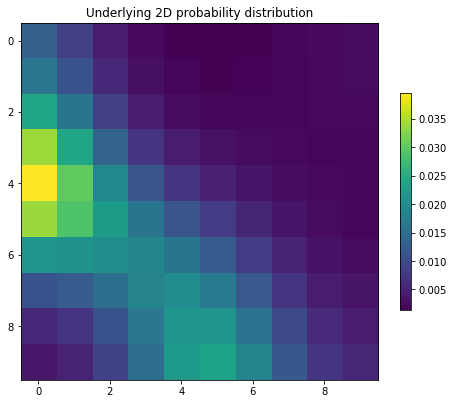

In [4]:
imshow(p_x)
plt.title('Underlying 2D probability distribution')
plt.gcf().set_size_inches(8, 8)
plt.colorbar(shrink=0.5)

To get the best return, we basically want to estimate this probability distribution from a small number of samples.

These estimates can be improved if we know anything about the probability distribution. In spatial data, one thing that might help is if we know that the distribution is 'smooth'.

In [5]:
def plot_samples_and_smoothed(n, sigma):
    plt.gcf().set_size_inches(12,4)
    subplot(1,3,1)
    X_sample = generate_samples(n)
    imshow(X_sample)
    axis('off')
    title('Samples')

    plt.subplot(1,3,2)
    X_smooth = gaussian_filter(X_sample.astype('float'), sigma)
    imshow(X_smooth)
    axis('off')
    title('Smoothed')

    subplot(1,3,3)
    imshow(p_x)
    axis('off')
    title('True distribution')

interact(plot_samples_and_smoothed, n=(1,50,1), sigma=(0.1,5,.2))


interactive(children=(IntSlider(value=25, description='n', max=50, min=1), FloatSlider(value=2.500000000000000…

<function __main__.plot_samples_and_smoothed(n, sigma)>

Choosing the right amount of smoothing seems to be important -- how can this be selected in practice?

One thing we can do is split our samples into training and validation sets. We can smoothing the training samples as above, and then see how 'surprising' the validation samples are. 

In [6]:
def indices_to_matrix(indices):
    X_flat = np.zeros(np.prod(grid_size))
    for i in range(len(indices)):
        X_flat[indices[i]] += 1
    X = np.reshape(X_flat, grid_size)
    return X

def split_samples(X_sample, val_proportion):
    X_sample_flat = X_sample.ravel()
    sample_indices = [] 
    for i in range(len(X_sample_flat)):
        if X_sample_flat[i]:
            sample_indices.extend([i]*X_sample_flat[i])
    sample_indices = np.random.permutation(sample_indices)
    n_val_samples = int(max(1, len(sample_indices)*val_proportion))
    train_indices = sample_indices[:-n_val_samples]
    val_indices = sample_indices[-n_val_samples:]
    X_train = indices_to_matrix(train_indices)
    X_val = indices_to_matrix(val_indices)    
    return X_train, X_val

def plot_samples_and_fitted_smoothing(n):
    # Take a sample and divide into training and validation samples
    X_sample = generate_samples(n)
    X_train, X_val = split_samples(X_sample, val_proportion)

    # Calculate log likelihoods for each setting of the smoothing parameter
    ll = []
    for i, sigma in enumerate(smoothing_values):
        
        X_smooth = gaussian_filter(X_train.astype('float'), sigma)
        
        X_smooth /= X_smooth.sum()
        X_smooth_log = np.log(X_smooth + 1e-8)
        
        ll.append(np.sum(X_smooth_log * X_val))

    # Plot the samples, likelihoods and estimated distribution
    subplot(1,3,1)
    imshow(X_sample)
    title('Sample')

    subplot(1,3,2)
    sigma_best = smoothing_values[np.argmax(ll)]
    plot(smoothing_values, ll)
    plot(sigma_best, ll[np.argmax(ll)], 'r*', ms=10)
    xlabel('sigma')
    ylabel('Log likelihood')

    subplot(1,3,3)
    X_smooth = gaussian_filter(X_sample.astype('float'), sigma_best)
    imshow(X_smooth)
    title('Estimated distribution')
    plt.gcf().set_size_inches(16,4)

    
val_proportion = 0.2
smoothing_values = np.arange(.1, 5, .1)
interact(plot_samples_and_fitted_smoothing, n=(2,50,1))

interactive(children=(IntSlider(value=26, description='n', max=50, min=2), Output()), _dom_classes=('widget-in…

<function __main__.plot_samples_and_fitted_smoothing(n)>

## Putting it into practice: cassava survey data
    

Let's look at a practical example, with data from the adhoc cassava disease survey project in the Makerere AI Lab. Farmers send in images from across Uganda, which are labelled. This dataset has a list of longitudes, latitudes, and whether the plant in question shows signs of Cassava Brown Streak Disease.

In [7]:
import pandas as pd
import shapefile
import GPy

df = pd.read_csv('cbsd_locations.csv')

# We'll use GP regression for this example, which takes a lot 
# of time and memory for more than a few thousand examples.
df = df.loc[::10,:]

df

,lon,lat,cbsd
0,33.156044,1.503085,0
10,33.161110,1.499818,1
20,32.885029,0.826809,0
30,33.156933,1.503510,1
40,32.618252,0.533957,0
50,33.749660,0.612305,0
60,33.159588,1.499290,0
70,33.155830,1.504217,0
80,33.161301,1.500316,1
90,33.070110,1.741124,1


Set up some plotting stuff, and have a look at the raw data.

In [8]:
ROI = shapefile.Reader("shapefiles/UGA_country").shapes()
ROI_coords = np.array(ROI[0].points)
xlim_l = min(ROI_coords[:, 0])
xlim_u = max(ROI_coords[:, 0])
ylim_l = min(ROI_coords[:, 1])
ylim_u = max(ROI_coords[:, 1])

def plot_ROI_outline(background_colour=(0,0,0), outline_colour=(1,1,1)):
    margin = .2
    ax = plt.gca()
    ax.fill(np.hstack((xlim_l-margin, xlim_u+margin, xlim_u+margin, 
                       xlim_l-margin, xlim_l-margin, ROI_coords[:, 0])), 
            np.hstack((ylim_l-margin, ylim_l-margin, ylim_u+margin, 
                        ylim_u+margin, ylim_l-margin, ROI_coords[:, 1])), 
            color=background_colour)
    ax.plot(ROI_coords[:, 0], ROI_coords[:, 1], color=outline_colour)
    ax.axis('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(xlim_l-margin, xlim_u+margin)
    ax.set_ylim(ylim_l-margin, ylim_u+margin)
    
# Precompute a grid of coordinates covering Uganda, which we will use as the positions to make predictions.
UG_min_lon = 29.571499
UG_max_lon = 35.000273
UG_min_lat = -1.47887
UG_max_lat = 4.234466
pixels_per_degree = 10.
numx = int((UG_max_lon-UG_min_lon)*pixels_per_degree)
numy = int((UG_max_lat-UG_min_lat)*pixels_per_degree)
mask = np.zeros((numy,numx))
x1 = np.linspace(UG_min_lon, UG_max_lon, numx)
x2 = np.linspace(UG_min_lat, UG_max_lat, numy)
xv, yv = meshgrid(x1, x2)

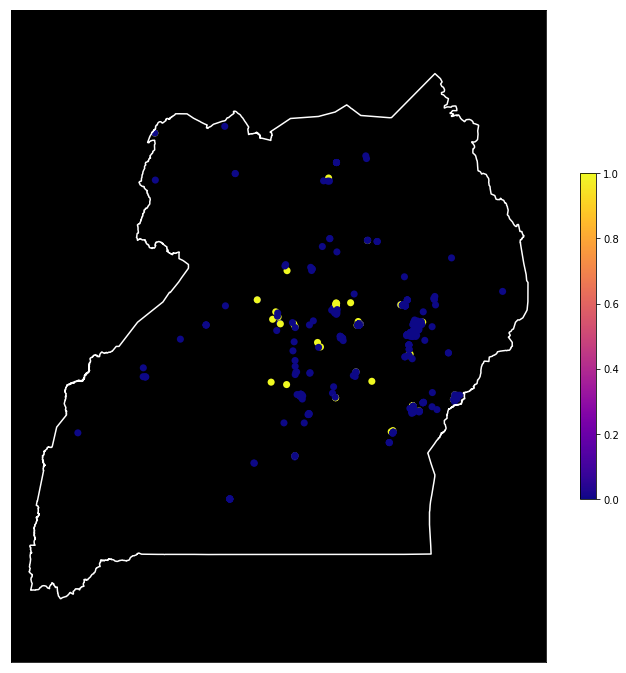

In [9]:
sc = scatter(df.lon, 
             df.lat, 
             c=df.cbsd, 
             cmap=plt.cm.plasma,
             s=50,alpha=1,
             edgecolors='none')
plt.colorbar(sc,shrink=.5)
gca().set_facecolor("black")
plot_ROI_outline()
plt.gcf().set_size_inches(12, 12)

Now try to estimate the distribution of CBSD across the country using Gaussian process regression. This is conceptually a bit like the above example, but with some extra features. One thing especially useful here

Text(0.5,1,'Estimated probability of CBSD infection')

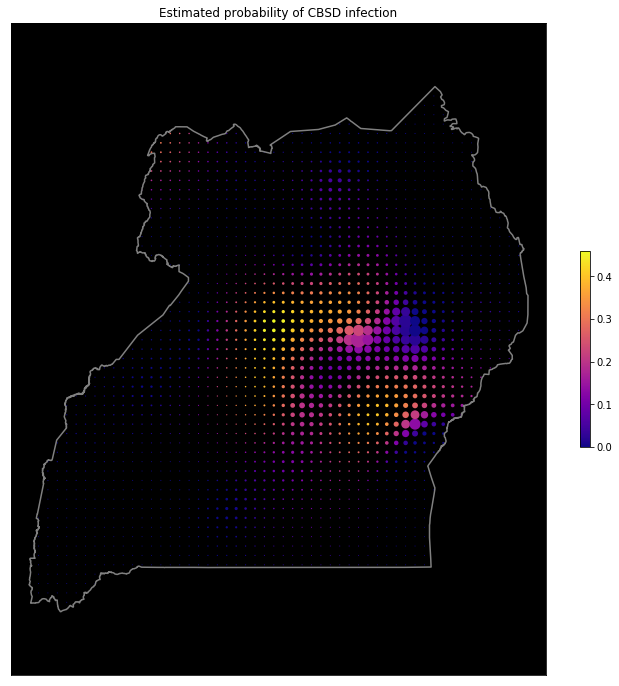

In [12]:
# The lengthscale parameter corresponds to sigma in the example above.
# The units are decimal degrees, where 1 degree equals approx 111km at the equator.
kernel = GPy.kern.RBF(2,lengthscale=.5)

# Create a simple GP model, which aims to predict CBSD status given location.
model = GPy.models.GPRegression(df.loc[:,('lon','lat')], 
                                np.array([df.loc[:,'cbsd']]).transpose(),kernel)

# OPTIONAL: optimise the parameters
#model.optimize(messages=True,max_f_eval = 1000)

# Make predictions at each point on the grid
ypred, S = model.predict(np.array([xv.ravel(),yv.ravel()]).transpose())

# It's possible to predict negative values, so only keep the positive part.
ypred[ypred<0] = 0

marker_scale_factor = 1
sc = scatter(xv.ravel(),
             yv.ravel(),
             c=ypred[:,0], 
             cmap=plt.cm.plasma,
             s=(marker_scale_factor/(S-1)),
             alpha=1,
             edgecolors='none',
             marker='o')
gca().set_facecolor("black")
plt.colorbar(sc,shrink=.3)
plot_ROI_outline(outline_colour=(.5,.5,.5))
gcf().set_size_inches(12,12)
title('Estimated probability of CBSD infection')